# Setup

In [0]:
!cd /content/
!mkdir data

!ls /content/data/

In [0]:
# Install kaggle packages
!pip install -q kaggle
!pip install -q kaggle-cli

# Colab's file access feature
from google.colab import files

     |████████████████████████████████| 81kB 2.9MB/s 
     |████████████████████████████████| 5.3MB 10.5MB/s 
     |████████████████████████████████| 112kB 63.0MB/s 
     |████████████████████████████████| 51kB 10.7MB/s 
     |████████████████████████████████| 112kB 50.3MB/s 


In [0]:
# Upload `kaggle.json` file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# Retrieve uploaded file
# print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then copy kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

User uploaded file "kaggle.json" with length 64 bytes
kaggle.json


In [0]:
!kaggle competitions download -c severstal-steel-defect-detection -p /content/data

 72% 5.00M/6.91M [00:00<00:00, 31.2MB/s]
100% 6.91M/6.91M [00:00<00:00, 33.8MB/s]
  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 125MB/s]
 99% 1.15G/1.16G [00:07<00:00, 210MB/s]
100% 1.16G/1.16G [00:07<00:00, 167MB/s]
 85% 110M/129M [00:00<00:00, 145MB/s] 
100% 129M/129M [00:00<00:00, 147MB/s]


In [0]:
import os
os.chdir('/content/data')
!unzip \*.zip

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  train_images.zip
  inflating: 5e581254c.jpg           
  inflating: fd2f7b4f4.jpg           
  inflating: 82f4c0b69.jpg           
  inflating: 18cc39190.jpg           
  inflating: bcef3582e.jpg           
  inflating: b1cf6d807.jpg           
  inflating: fadccb348.jpg           
  inflating: 6bdf447c5.jpg           
  inflating: 29e57e1de.jpg           
  inflating: 0da296499.jpg           
  inflating: 049fb17a1.jpg           
  inflating: c6bbd2e4f.jpg           
  inflating: a4a007ea2.jpg           
  inflating: 8f5e37d0a.jpg           
  inflating: dff1d028a.jpg           
  inflating: 6adf77c70.jpg           
  inflating: e81ee8548.jpg           
  inflating: 440ce15f1.jpg           
  inflating: 1483bc52d.jpg           
  inflating: 4783eb121.jpg           
  inflating: e865201fb.jpg           
  inflating: 7b90bf5c9.jpg           
  inflating: 86ded721f.jpg           
  inflating: 17e12e6cb.jpg          

In [0]:
!rm sample_submission.csv test_images.zip train.csv.zip train_images.zip train.csv

In [0]:
!kaggle competitions download -c severstal-steel-defect-detection -p /content/

  0% 0.00/6.91M [00:00<?, ?B/s]
100% 6.91M/6.91M [00:00<00:00, 113MB/s]
  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 127MB/s]
 99% 1.16G/1.16G [00:35<00:00, 20.0MB/s]
100% 1.16G/1.16G [00:35<00:00, 35.0MB/s]
 98% 127M/129M [00:04<00:00, 26.4MB/s]
100% 129M/129M [00:04<00:00, 29.9MB/s]


In [0]:
!ls /content/
os.chdir('/content/')

!rm /content/test_images.zip /content/train_images.zip
!unzip /content/train.csv.zip -d /content/
!rm /content/train.csv.zip

data	     sample_data	    test_images.zip  train_images.zip
kaggle.json  sample_submission.csv  train.csv.zip
Archive:  /content/train.csv.zip
  inflating: /content/train.csv      


# Functions

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv2
import numpy as np
import os

from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


from skimage.io import imread
from skimage.morphology import label

# change current dir to content
os.chdir('/content')

In [0]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    # make an array of zeros
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

In [0]:
def read_and_prep_images(count):
  img_paths = [os.path.join('/content/data/', row['ImageId_ClassId']) for _, row in images[:count].iterrows()]
  imgs = [load_img(img_path) for img_path in img_paths]
  
  img_array = [np.array(img) for img in imgs]
  
  return img_array

In [0]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [0]:
  
# rle decode is the same as rle2mask
def rle_decode(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype('uint8')
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

In [0]:
def masks_as_image(rle, imgshape, img):
    # Take the individual ship masks and create a single mask array for all ships
    
    #if isinstance(in_mask_list, list):
    
    mask = rle_decode(rle, imgshape)
    img[mask==1,0] = 255
    
    return img

In [0]:
def viz_rand_defects(defect_type):
  
  fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(20, 20))

  axes = axes.flatten()

  tem3 = train_masked_df.query('defectType == "{}"'.format(defect_type)) 

  for i in range(20):
    ax = axes[i]
    fn = tem3['ImageId'].iloc[i]
    img = cv2.imread('/content/data/' + fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = rle2mask( tem3['EncodedPixels'].iloc[i], img.shape  )
    img[mask==1,0] = 255

    ax.imshow(img)
    ax.set_axis_off()
    id = tem3['ImageId'].iloc[i]
    def_type = tem3['defectType'].iloc[i]
    ax.set_title('defect type for {} is: '.format(id) + def_type)

  plt.tight_layout()
  plt.show()

In [0]:
train_df = pd.read_csv('train.csv')
train_df['isMasked'] = ~train_df['EncodedPixels'].isnull()

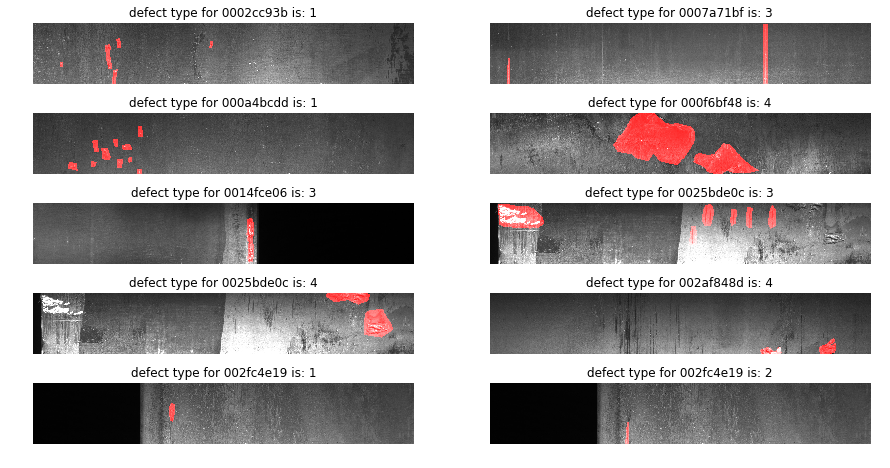

In [0]:
# Quick Viz

columns = 2
rows = 5  
  
fig, axes = plt.subplots(figsize=(15, 8), nrows=rows, ncols=columns)
axes = axes.flatten()

# makee a new df, train_masked which only contains all the images with mask
train_masked_df = train_df[train_df['isMasked']]

for i in range(10):
    ax = axes[i]
    fn = train_masked_df['ImageId_ClassId'].iloc[i].split('_')[0]
    img = cv2.imread('/content/data/' + fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = rle2mask( train_masked_df['EncodedPixels'].iloc[i], img.shape  )
    
    # slicing based on the mask and make the corresponding pixel values 255
    img[mask==1,0] = 255

    ax.imshow(img)
    ax.set_axis_off()
    id, _= train_masked_df['ImageId_ClassId'].iloc[i].split('.')
    def_type = train_masked_df['ImageId_ClassId'].iloc[i][-1]
    ax.set_title('defect type for {} is: '.format(id) + def_type)

plt.show()

In [0]:
images = pd.DataFrame(train_df.copy())
images.drop(columns=['EncodedPixels', 'isMasked'], inplace=True)

images['ImageId_ClassId'] = images['ImageId_ClassId'].str.split('_').str[0]
images.drop_duplicates(keep='first', inplace=True)
images.head(10)


,ImageId_ClassId
0,0002cc93b.jpg
4,00031f466.jpg
8,000418bfc.jpg
12,000789191.jpg
16,0007a71bf.jpg
20,000a4bcdd.jpg
24,000f6bf48.jpg
28,0014fce06.jpg
32,001982b08.jpg
36,001d1b355.jpg


# Visualizing different defects
TODO: show the masked and original image. This will make the comparison easier.

In [0]:
train_masked_df.reset_index(inplace=True, drop=True)
tem = pd.DataFrame(train_masked_df['ImageId_ClassId'].str.split('_').tolist(), columns=['ImageId', 'defectType'])
train_masked_df['defectType'] = tem['defectType']
train_masked_df['ImageId'] = tem['ImageId']

train_masked_df.drop(columns='ImageId_ClassId', inplace=True)
train_masked_df = train_masked_df[['ImageId', 'defectType', 'isMasked', 'EncodedPixels']]
train_masked_df.head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://panda

,ImageId,defectType,isMasked,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,True,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,True,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,True,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,True,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,True,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6,0025bde0c.jpg,4,True,315139 8 315395 15 315651 16 315906 17 316162 ...
7,002af848d.jpg,4,True,290800 6 291055 13 291311 15 291566 18 291822 ...
8,002fc4e19.jpg,1,True,146021 3 146275 10 146529 40 146783 46 147038 ...
9,002fc4e19.jpg,2,True,145658 7 145901 20 146144 33 146386 47 146629 ...


In [0]:
viz_rand_defects(3)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
viz_rand_defects(1)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
viz_rand_defects(4)

Output hidden; open in https://colab.research.google.com to view.

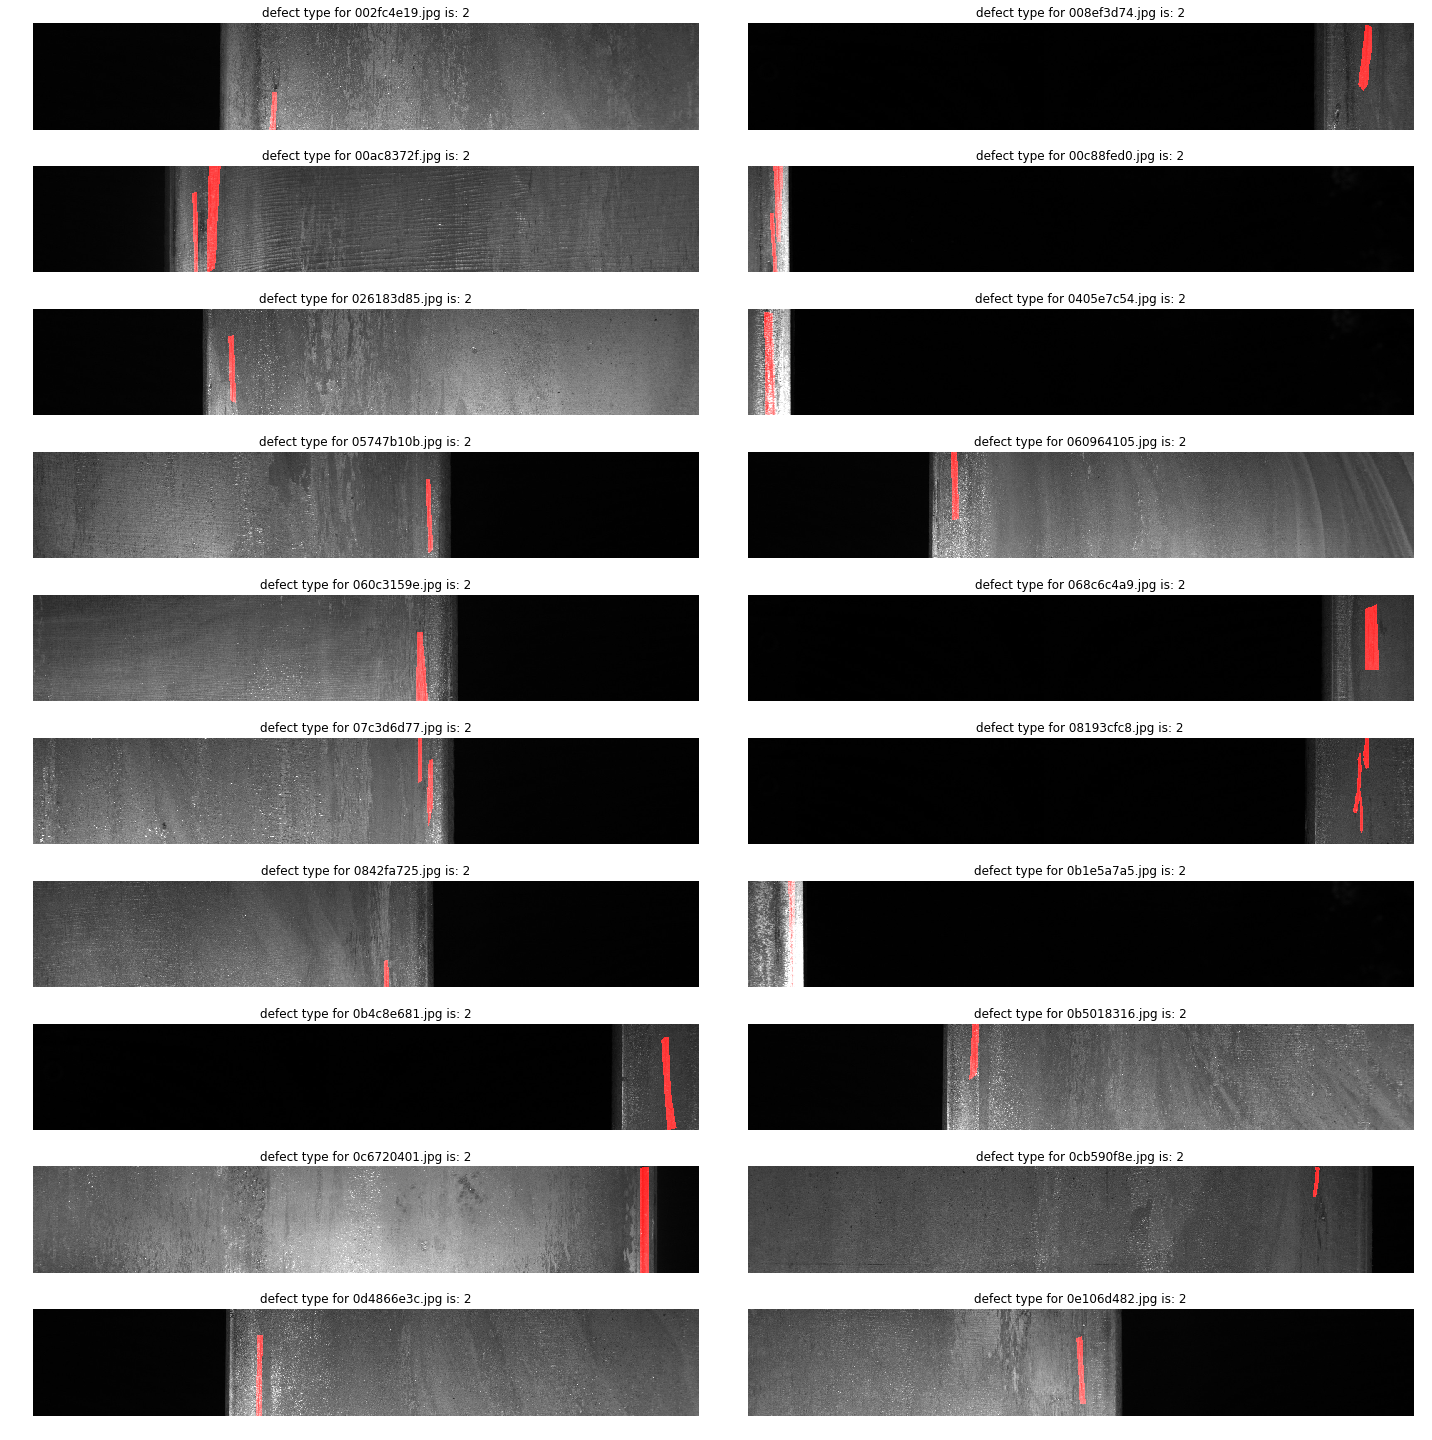

In [0]:
viz_rand_defects(2)

In [0]:
# clearly the dataset is imbalanced
train_masked_df['defectType'].value_counts()

3    5150
1     897
4     801
2     247
Name: defectType, dtype: int64

# Dealing with the imbalanced dataset
Reorganized train_masked_df into ImageId, defectType isMasked and EndcodedPixels format.

Upsample and downsample for minority class and majority classes respectively

In [0]:
tem3 = train_masked_df.query('defectType == "3"')
tem1 = train_masked_df.query('defectType == "1"')
tem4 = train_masked_df.query('defectType == "4"')
tem2 = train_masked_df.query('defectType == "2"')

from sklearn.utils import resample


tem3 = resample(tem3, 
                 replace=False,     # downsample with replacement
                 n_samples=800,    # to match majority class
                 random_state=123)

tem1 = resample(tem1, 
                 replace=False,     # downsample with replacement
                 n_samples=800,    # to match majority class
                 random_state=123)

tem4 = resample(tem4, 
                 replace=False,     # downsample without replacement
                 n_samples=800,    # to match majority class
                 random_state=123)

tem2 = resample(tem2, 
                 replace=True,     # upsample with replacement
                 n_samples=800,    # to match majority class
                 random_state=123)

balanced_df = pd.concat([tem3, tem1, tem4, tem2], axis=0)

# check with value counts
balanced_df['defectType'].value_counts()

2    800
4    800
1    800
3    800
Name: defectType, dtype: int64

In [0]:
balanced_df.reset_index(inplace=True, drop=True)

# Unet
Train test split

Make a custom Image data generator to 1. get the images from the prespecified directory path. 2. Decode the respective rle.
- Generator extracts the data row wise from a shuffled dataframe

Note: It'll be easier if we have training and validation data seperated in 2 directories. (This is a heads up for next time)

- Make another generator for data augmentation. 


Note: the image and label must be augmented simultaneously in the same way.

In [0]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from skimage.util import montage # To ease visualization of generated images

In [0]:
# Model Parameters
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'

#downsampling inside the network
NET_SCALING = None

#downsampling in preprocessing
IMG_SCALING =(1,1)

#number of validation images to use
VALID_IMG_COUNT = 400

#maximum number of steps per epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [0]:
#train test split
train_ids, valid_ids = train_test_split(balanced_df['ImageId'], 
                                        test_size=0.3,
                                        stratify=balanced_df['defectType'],
                                        random_state=42)
# just to check the distribution
# balanced_df.iloc[train_ids.index]['defectType'].value_counts()


train_df = balanced_df.loc[train_ids.index]
valid_df = balanced_df.loc[valid_ids.index]

## Generators

In [0]:
# This generator must be able to generate data on the fly, but in batches
# We can use the montage function to combine the data
# before visualizing the image since the generator yields batches with a size of 4


image_dir = '/content/data/'

def make_image_gen(in_df=balanced_df, batch_size = BATCH_SIZE, seed=42):
  '''
  Gets images on the fly from the prespecified directory.
  Decode the rle into masked image.
  '''
  
  in_df = pd.DataFrame(in_df.copy())
  
  #shuffle
  in_df = in_df.sample(frac=1, random_state=seed)
  
  out_rgb=[]
  out_mask = []
  
  while True:
    
    for _, row in in_df.iterrows():     

      imgId = row['ImageId']
      rle = row['EncodedPixels']

      imgPath = os.path.join(image_dir, imgId)
      img = cv2.imread(imgPath)

      img_masked = rle_decode(rle, img.shape)

      out_rgb += [img]
      out_mask += [img_masked]
      if len(out_rgb) >= batch_size:
        yield np.stack(out_rgb, 0)/255.0, np.expand_dims(np.stack(out_mask, 0), axis=3)
        out_rgb, out_mask=[], []

In [0]:
# data generator args
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                  data_format = 'channels_last')
if AUGMENT_BRIGHTNESS:
  dg_args['brightness_range'] = [0.5, 1.5]
  
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
  dg_args.pop('brightness_range')
  
label_gen = ImageDataGenerator(**dg_args)


# Create an augmentation image data generator

def create_aug_gen(in_gen, seed=42):
  '''
  Does real time augmentation on the image data supplied by make_image_gen
  
  '''
  
  for in_x, in_y in in_gen:
    
    g_x = image_gen.flow(255*in_x, 
                         batch_size = in_x.shape[0], 
                         seed = seed, 
                         shuffle=True)
    g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
    yield next(g_x)/255.0, next(g_y)

Let's take a look at the data generated by our data generators. But before that we need to fit the generators on training and validtion data first

In [0]:
# Fit the generator on training data first
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())
print("-"*20)

# Fit the generator on validation data
valid_gen = make_image_gen(valid_df)
valid_x, valid_y = next(valid_gen)
print('x', valid_x.shape, valid_x.min(), valid_x.max())
print('y', valid_y.shape, valid_y.min(), valid_y.max())

x (4, 256, 1600, 3) 0.0 1.0
y (4, 256, 1600, 1) 0 1
--------------------
x (4, 256, 1600, 3) 0.0 1.0
y (4, 256, 1600, 1) 0 1


In [0]:
# define our own montage function for rgb
montage_rgb = lambda x: np.stack([montage(x[:,:,:,i]) for i in range (x.shape[3])], -1)


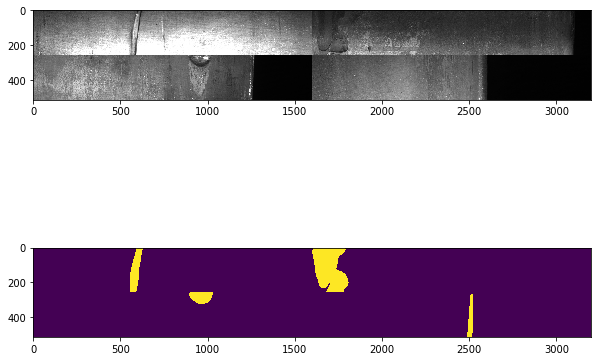

In [0]:
# viz the data generated by make_image_gen
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

ax1.imshow(montage_rgb(train_x))

ax2.imshow(montage(train_y[:,:,:, 0]))
plt.show()

x (4, 256, 1600, 3) float32 0.0 1.0
y (4, 256, 1600, 1) float32 0.0 1.0


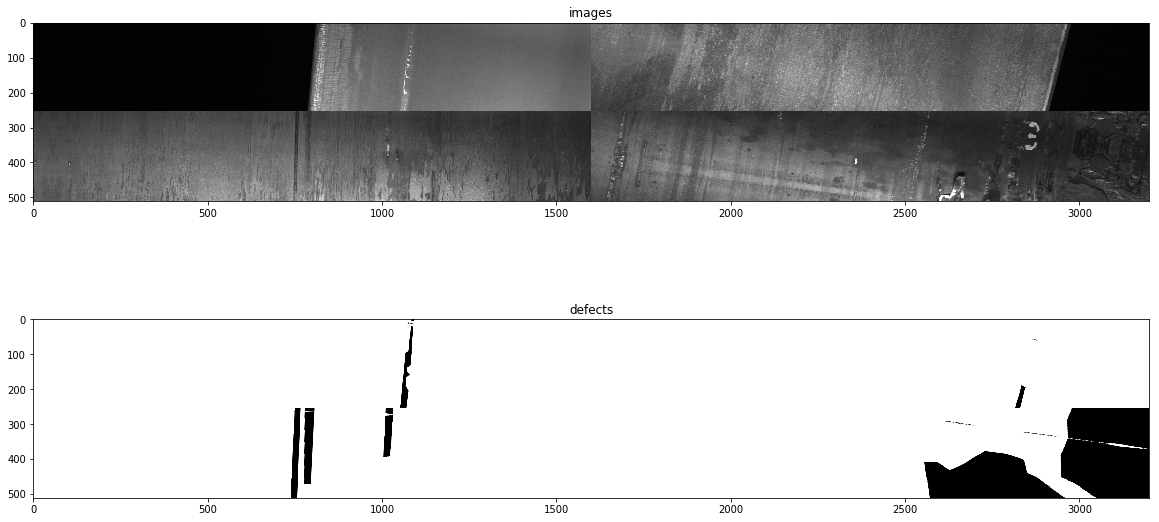

In [0]:
# viz the ttrnsformed(augmented data)
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('defects')
plt.show()

# Training

In [0]:
!pip install segmentation-models
import segmentation_models as sm

     |████████████████████████████████| 51kB 2.4MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 


/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [0]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
K.set_image_data_format('channels_last')


def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
  
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
  
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)


In [0]:
model = sm.Unet()
model.summary()  
model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])




58892288/58889256 [==============================] - 1s 0us/step

Model: "u-vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
________________________

# Callbacks
TODO: Try to save the weights locally into your drive

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('unet_seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but colab's time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(train_df))

loss_history = [model.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks_list, # this allows our model to start from the checkpoints in callbacks_list
                            workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/5


KeyboardInterrupt: ignored